In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pprint import pprint
import pandas as pd
import numpy as np
# import eli5
import time
from sklearn.model_selection import cross_validate
import img_utils

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
%matplotlib inline

In [2]:
sizes = [1, 2, 4, 8, 16, 32, 64, 128]

def get_features(sample, col_names):
    features = {col_names[i+1]: float(sample[i]) for i in range(sample.shape[0])}
    features['bias'] = 1.0
    return features


In [ ]:
metrics_crf = {label: {'mean':[], 'std':[]} for label in ['fit_time', 'score_time', 'test_score', 'train_score']}

for size in sizes:
    np.random.seed(42)
    data = pd.read_csv(f'data/resized_data_scaled_{size}.csv')
    col_names = data.columns
    
    Y = [[str(int(y[0]))] for y in data[['y']].values.astype(np.uint8)]
    X = data[col_names[1:]].values
    
    X = [[get_features(X[i], col_names)] for i in range(X.shape[0])]
    
    model = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )
    
    metrics = {'fit_time':[], 'score_time':[], 'train_score':[], 'test_score':[]}
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
        start = time.time()
        model.fit(X_train, y_train)
        metrics['fit_time'].append(time.time() - start)
        metrics['train_score'].append(model.score(X_train, y_train))
        start = time.time()
        metrics['test_score'].append(model.score(X_test, y_test))
        metrics['score_time'].append(time.time() - start)
    
    print(len(model.state_features_))     

    pprint(metrics)
    for key in metrics:
        metrics_crf[key]['mean'].append(np.array(metrics[key]).mean())
        metrics_crf[key]['std'].append(np.array(metrics[key]).std())

In [ ]:
crf_df = pd.DataFrame.from_dict({f'{label}_{sub_label}': metrics_crf[label][sub_label] 
                                 for label in metrics_crf for sub_label in metrics_crf[label]})
crf_df = crf_df.rename({i: 2**i for i in range(9)}, axis='index')
# crf_df.to_csv('crf_data.csv')

In [3]:
crf_df = pd.read_csv('crf_data.csv', index_col=0)
crf_df

,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_score_mean,test_score_std,train_score_mean,train_score_std
1,0.375103,0.013478,0.005266,0.001299,0.577093,0.016654,0.592924,0.006456
2,0.541932,0.010334,0.006776,0.000549,0.627019,0.008355,0.628510,0.000472
4,1.307829,0.050905,0.014513,0.000045,0.694567,0.005851,0.692173,0.002657
8,4.664736,0.403531,0.046780,0.000288,0.722467,0.006484,0.717801,0.001609
16,19.929927,1.787359,0.168854,0.001765,0.750367,0.011975,0.744572,0.001289
32,70.084451,3.777611,0.703855,0.003778,0.749266,0.012275,0.745184,0.001985
64,376.427484,17.483100,5.489618,0.319732,0.756975,0.008159,0.750979,0.001127
128,5757.700280,224.643998,43.876908,2.759357,0.754405,0.008578,0.753387,0.000208


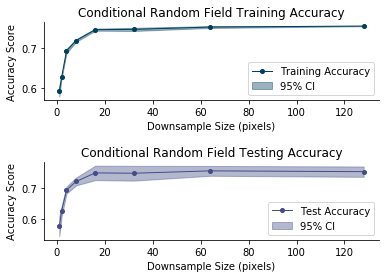

In [10]:
fig, axs = img_utils.make_subplot(rows=2, cols=1)
img_utils.lineplot_ci(axs[0], crf_df.index, 
                   list(crf_df['train_score_mean']), list(crf_df['train_score_std']), 
                   label="Training Accuracy", title="Conditional Random Field Training Accuracy",
                   x_label="Downsample Size (pixels)", y_label="Accuracy Score",
                   color=0)
img_utils.lineplot_ci(axs[1], crf_df.index, 
                   list(crf_df['test_score_mean']), list(crf_df['test_score_std']), 
                   label="Test Accuracy", title="Conditional Random Field Testing Accuracy",
                   x_label="Downsample Size (pixels)", y_label="Accuracy Score",
                   color=1)
plt.subplots_adjust(hspace = 0.8)
plt.savefig('../report/crf_graph_score.png', dpi=300, bbox_inches='tight')

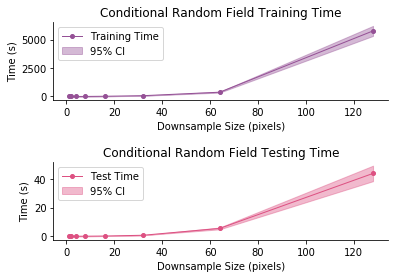

In [11]:
fig, axs = img_utils.make_subplot(rows=2, cols=1)
img_utils.lineplot_ci(axs[0], crf_df.index, 
                   list(crf_df['fit_time_mean']), list(crf_df['fit_time_std']), 
                   label="Training Time", title="Conditional Random Field Training Time",
                   x_label="Downsample Size (pixels)", y_label="Time (s)",
                   color=2, loc="upper left")
img_utils.lineplot_ci(axs[1], crf_df.index, 
                   list(crf_df['score_time_mean']), list(crf_df['score_time_std']), 
                   label="Test Time", title="Conditional Random Field Testing Time",
                   x_label="Downsample Size (pixels)", y_label="Time (s)",
                   color=3, loc="upper left")
plt.subplots_adjust(hspace = 0.8)
plt.savefig('../report/crf_graph_time.png', dpi=300, bbox_inches='tight')

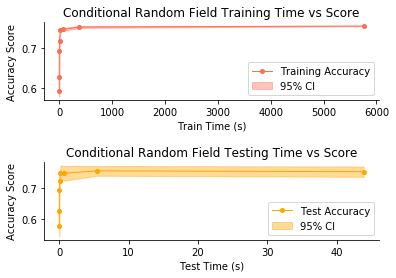

In [12]:
fig, axs = img_utils.make_subplot(rows=2, cols=1)
img_utils.lineplot_ci(axs[0], list(crf_df['fit_time_mean']), 
                   list(crf_df['train_score_mean']), list(crf_df['train_score_std']), 
                   label="Training Accuracy", title="Conditional Random Field Training Time vs Score",
                   x_label="Train Time (s)", y_label="Accuracy Score",
                   color=4)
img_utils.lineplot_ci(axs[1], list(crf_df['score_time_mean']), 
                   list(crf_df['test_score_mean']), list(crf_df['test_score_std']), 
                   label="Test Accuracy", title="Conditional Random Field Testing Time vs Score",
                   x_label="Test Time (s)", y_label="Accuracy Score",
                   color=5)
plt.subplots_adjust(hspace = 0.8)
plt.savefig('../report/crf_graph_time_score.png', dpi=300, bbox_inches='tight')